In [4]:
%%capture
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay

In [5]:
#!pip install pyglet==v1.3.2

In [6]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical

In [9]:
import copy
import random
from collections import OrderedDict


**OpenAI Gym**

We're gonna spend several next weeks learning algorithms that solve decision processes. We are then in need of some interesting decision problems to test our algorithms.

That's where OpenAI gym comes into play. It's a python library that wraps many classical decision problems including robot control, videogames and board games.

So here's how it works:


reset() - reset environment to initial state, return first observation

render() - show current environment state (a more colorful version :) )

step(a) - commit action a and return (new observation, reward, is done, info)


In [10]:
import gym

# Time to play

Try tweaking t or action strategy

**Remember**: Target is to reach to flag

In [22]:
class NN2Layers(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Sequential(
      nn.Linear(4,128, bias=True),
      nn.ReLU(),
      nn.Linear(128,2, bias=True),
      nn.Softmax(dim=1)
    )

    for param in self.parameters():
      param.requires_grad = False

  def forward(self, inputs):
    x = self.fc(inputs)
    return x

  def select_action_from_policy(model, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = model(state)
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

  def get_weights(self):
    parameters = self.state_dict().values()
    parameters = [p.flatten() for p in parameters]
    parameters = torch.cat(parameters, 0)
    return parameters.detach().numpy()

  def update_weights(self, weights):
    weights = torch.from_numpy(weights)
    shapes = [x.shape for x in self.state_dict().values()]
    shapes_prod = [torch.tensor(s).numpy().prod() for s in shapes]

    partial_split = weights.split(shapes_prod)
    model_weights = []
    for i in range(len(shapes)):
        model_weights.append(partial_split[i].view(shapes[i]))
    state_dict = OrderedDict(zip(self.state_dict().keys(), model_weights))
    self.load_state_dict(state_dict)

In [23]:
class NN3LayersDropout(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(4,128, bias=True)
    self.l2 = nn.Linear(128, 512, bias=True)
    self.dropout = nn.Dropout(p=0.1)
    self.l3 = nn.Linear(512,1, bias=True)
    self.t = nn.Tanh()

    # torch.nn.init.xavier_uniform(self.weight)
    # self.bias.data.fill_(0.00)
    for param in self.parameters():
      param.requires_grad = False

  def forward(self, inputs):
    x = F.relu(self.l1(inputs))
    x = F.relu(self.l2(x))
    x = self.dropout(x)
    x= self.l3(x)
    x = self.t(x)
    return x

  def select_action_from_policy(model, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = model(state)
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)
  
  def get_weights(self):
    parameters = self.state_dict().values()
    parameters = [p.flatten() for p in parameters]
    parameters = torch.cat(parameters, 0)
    return parameters.detach().numpy()

  def update_weights(self, weights):
    weights = torch.from_numpy(weights)
    shapes = [x.shape for x in self.state_dict().values()]
    shapes_prod = [torch.tensor(s).numpy().prod() for s in shapes]

    partial_split = weights.split(shapes_prod)
    model_weights = []
    for i in range(len(shapes)):
        model_weights.append(partial_split[i].view(shapes[i]))
    state_dict = OrderedDict(zip(self.state_dict().keys(), model_weights))
    self.load_state_dict(state_dict)

In [24]:
def get_starting_pop(num_agents):
  agents = []
  for _ in range(num_agents):
    agent = NN2Layers()

    for param in agent.parameters():
      param.requires_grad = False

    agents.append(agent)
  return agents

In [52]:
def mutate(agent, mutation_rate=0.7, max_change=0.5):
  # child_agent = copy.deepcopy(agent)
  child_weights = agent.get_weights()
  mutation_power = 0.02 #hyper-parameter
  severity = np.random.randint(10, 20) # change between 10 and 20 params
  div = max_change*1000
  if np.random.rand() < mutation_rate:
    for _ in range(severity):
      position = np.random.randint(0, child_weights.shape[0])

      change = np.random.randint(0,div)/1000

      if np.random.choice(['add','sub']) == 'add':
          child_weights[position] = child_weights[position] + change
      else:
          child_weights[position] = child_weights[position] - change
  
  agent.update_weights(child_weights)

  # return child_agent

  # for param in child_agent.parameters():
  #   if(len(param.shape)==2): #weights of linear layer
  #     for i in range(param.shape[0]):
  #       for j in range(param.shape[1]):
  #           param[i][j] += mutation_power * np.random.randn()

  #   elif(len(param.shape)==1): #biases of linear layer or conv layer
  #     for i in range(param.shape[0]):
  #       param[i] += mutation_power * np.random.randn()

  # return child_agent

In [53]:
def crossover(parent1, parent2, crossover_rate):
  child1_weights = parent1.get_weights()
  child2_weights = parent2.get_weights()
  position = np.random.randint(0, child1_weights.shape[0])

  if np.random.rand() < crossover_rate:
    child1_weights[position:], child2_weights[position:] = child2_weights[position:], child1_weights[position:]
  
  child1 = NN2Layers()
  child1.update_weights(child1_weights)
  child2 = NN2Layers()
  child2.update_weights(child2_weights)
  return child1, child2

In [54]:
def roulette_selection(agents, rewards):
    total_rewards = np.sum(rewards)
    selection_probabilities = [reward / total_rewards for reward in rewards]
    pick = np.random.choice(len(agents), p=selection_probabilities)
    return agents[pick], rewards[pick]

In [55]:
def get_children(agents, rewards):
  children_agents = []

  for i in range(0, len(agents)-1, 2):
    # parent selection
    parent1, pfit1 = roulette_selection(agents, rewards)
    parent2, pfit2 = roulette_selection(agents, rewards)

    # crossover
    child1, child2 = crossover(parent1, parent2, 0.9)

    # mutation
    mutate(child1)
    mutate(child2)

    # evaluate fitness of children
    cfit1 = run_agent(child1)
    cfit2 = run_agent(child2)

    if cfit1 + cfit2 > pfit1 + pfit2:
      # print("adding children")
      children_agents += [child1, child2]
    else:
      # print("adding parents")
      children_agents += [parent1, parent2]
  return children_agents

In [56]:
def run_agent(agent):
  agent.eval()
  observation = env.reset()
  r=0
  render = False
  for _ in range(250):
    if render:
      env.render()
    action, prob = agent.select_action_from_policy(observation)
    observation, reward, done, info = env.step(action)
    r += reward

    if done:
      break
  return r

In [57]:
def run_rewards(agents, runs):
  rewards = []
  for agent in agents:
    score = 0.0
    for i in range(runs):
      score += run_agent(agent)
    rewards.append(score/runs)
  return rewards

In [58]:
torch.set_grad_enabled(False)

num_agents = 500
generations = 100

env = gym.make("CartPole-v0")
agents = get_starting_pop(num_agents)

progress_single = []
progress_top_5 = []
progress_mean = []

for generation in range(generations):
  rewards = run_rewards(agents, 3) # avg of 3 runs?

  # sort by rewards
  sorted_parents = np.argsort(rewards)[::-1]
  
  top_rewards = []
  for best_parent in sorted_parents[:20]:
    top_rewards.append(rewards[best_parent])
  
  print(f"Gen {generation}, Mean rewards: {np.mean(rewards):.4f},  Mean of top 5: {np.mean(top_rewards[:5]):.4f}, Top agent: {top_rewards[0]:.4f}")
  progress_single.append(top_rewards[0])
  progress_top_5.append(np.mean(top_rewards[:5]))
  progress_mean.append(np.mean(rewards))

  agents = get_children(agents, rewards)

Gen 0, Mean rewards: 21.6047,  Mean of top 5: 49.4000, Top agent: 58.3333
Gen 1, Mean rewards: 22.2533,  Mean of top 5: 45.7333, Top agent: 51.3333
Gen 2, Mean rewards: 22.2347,  Mean of top 5: 47.9333, Top agent: 51.0000
Gen 3, Mean rewards: 22.6787,  Mean of top 5: 47.6000, Top agent: 50.6667
Gen 4, Mean rewards: 22.9053,  Mean of top 5: 54.7333, Top agent: 63.3333
Gen 5, Mean rewards: 22.9547,  Mean of top 5: 58.4000, Top agent: 66.0000
Gen 6, Mean rewards: 23.5253,  Mean of top 5: 53.9333, Top agent: 62.6667
Gen 7, Mean rewards: 23.3413,  Mean of top 5: 54.8667, Top agent: 65.3333
Gen 8, Mean rewards: 24.5460,  Mean of top 5: 60.1333, Top agent: 62.3333
Gen 9, Mean rewards: 24.7893,  Mean of top 5: 55.9333, Top agent: 59.6667
Gen 10, Mean rewards: 24.7600,  Mean of top 5: 60.9333, Top agent: 68.6667
Gen 11, Mean rewards: 25.2093,  Mean of top 5: 58.3333, Top agent: 60.0000
Gen 12, Mean rewards: 26.0000,  Mean of top 5: 69.6000, Top agent: 86.0000
Gen 13, Mean rewards: 26.3587,  Mea

KeyboardInterrupt: ignored

In [59]:
import seaborn as sns
import pandas as pd

In [62]:
print(generations)

100


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


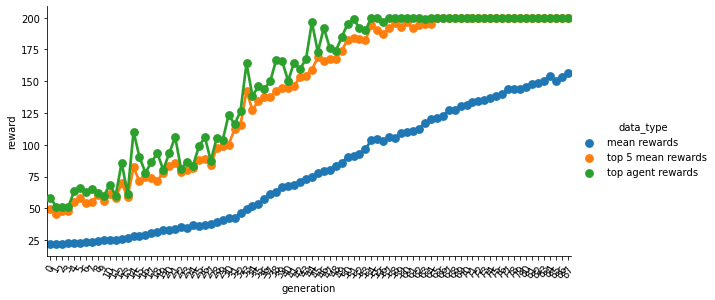

In [63]:
#run mutation rate = 0.85, mutation power = 0.02, nn2 3 layers + dropout
d = {'generation': range(len(progress_mean)), 'mean rewards': progress_mean, 'top 5 mean rewards': progress_top_5, 'top agent rewards': progress_single }
df = pd.DataFrame(d)

df = df.melt('generation', var_name='data_type', value_name='reward')

g = sns.catplot(x="generation", y="reward", hue='data_type', kind="point", data=df, size=4, aspect = 2).set_xticklabels(rotation=60)

# Finished results

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


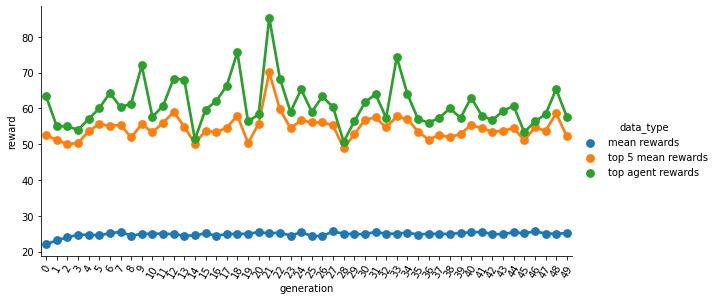

In [58]:
#run mutation rate = 0.85, mutation power = 0.02, nn1 2 layers
d = {'generation': range(generations), 'mean rewards': progress_mean, 'top 5 mean rewards': progress_top_5, 'top agent rewards': progress_single }
df = pd.DataFrame(d)

df = df.melt('generation', var_name='data_type', value_name='reward')

g = sns.catplot(x="generation", y="reward", hue='data_type', kind="point", data=df, size=4, aspect = 2).set_xticklabels(rotation=60)

Generation 0, Mean rewards: 21.552,  Mean of top 5: 48.06666666666667
Generation 1, Mean rewards: 23.220238095238095,  Mean of top 5: 53.666666666666664
Generation 2, Mean rewards: 24.443569553805776,  Mean of top 5: 60.333333333333336
Generation 3, Mean rewards: 25.078125,  Mean of top 5: 53.133333333333326
Generation 4, Mean rewards: 25.72545219638243,  Mean of top 5: 59.06666666666666
Generation 5, Mean rewards: 27.644871794871797,  Mean of top 5: 63.2
Generation 6, Mean rewards: 28.73155216284987,  Mean of top 5: 61.33333333333333
Generation 7, Mean rewards: 30.27020202020202,  Mean of top 5: 70.79999999999998
Generation 8, Mean rewards: 33.212406015037594,  Mean of top 5: 87.73333333333333
Generation 9, Mean rewards: 34.06716417910448,  Mean of top 5: 88.73333333333332
Generation 10, Mean rewards: 34.1216049382716,  Mean of top 5: 77.66666666666666
Generation 11, Mean rewards: 34.1452205882353,  Mean of top 5: 74.53333333333333
Generation 12, Mean rewards: 35.10401459854015,  Mean of top 5: 84.73333333333333
Generation 13, Mean rewards: 36.67632850241546,  Mean of top 5: 87.4
Generation 14, Mean rewards: 38.367505995203835,  Mean of top 5: 83.06666666666668
Generation 15, Mean rewards: 37.10833333333333,  Mean of top 5: 85.53333333333333
Generation 16, Mean rewards: 39.989952718676115,  Mean of top 5: 92.4
Generation 17, Mean rewards: 40.83978873239437,  Mean of top 5: 87.13333333333334
Generation 18, Mean rewards: 43.163752913752916,  Mean of top 5: 101.2
Generation 19, Mean rewards: 43.21875,  Mean of top 5: 107.86666666666667
Generation 20, Mean rewards: 45.40114942528736,  Mean of top 5: 106.33333333333334
Generation 21, Mean rewards: 47.47260273972603,  Mean of top 5: 107.53333333333333
Generation 22, Mean rewards: 50.4109977324263,  Mean of top 5: 111.46666666666667
Generation 23, Mean rewards: 51.810810810810814,  Mean of top 5: 110.73333333333332
Generation 24, Mean rewards: 52.256711409395976,  Mean of top 5: 110.73333333333332
Generation 25, Mean rewards: 54.807222222222215,  Mean of top 5: 122.53333333333333
Generation 26, Mean rewards: 55.891280353200884,  Mean of top 5: 131.4
Generation 27, Mean rewards: 57.228070175438596,  Mean of top 5: 122.26666666666665
Generation 28, Mean rewards: 59.39161220043574,  Mean of top 5: 126.46666666666667
Generation 29, Mean rewards: 59.98863636363637,  Mean of top 5: 133.2
Generation 30, Mean rewards: 58.29354838709678,  Mean of top 5: 127.86666666666665
Generation 31, Mean rewards: 62.20032051282051,  Mean of top 5: 142.33333333333331
Generation 32, Mean rewards: 62.89225053078557,  Mean of top 5: 149.66666666666669
Generation 33, Mean rewards: 67.54799578059072,  Mean of top 5: 141.06666666666666
Generation 34, Mean rewards: 71.89989517819706,  Mean of top 5: 146.66666666666669
Generation 35, Mean rewards: 70.50520833333334,  Mean of top 5: 149.93333333333334
Generation 36, Mean rewards: 73.86749482401656,  Mean of top 5: 155.53333333333336
Generation 37, Mean rewards: 71.1738683127572,  Mean of top 5: 153.73333333333335
Generation 38, Mean rewards: 72.81697341513292,  Mean of top 5: 155.4666666666667
Generation 39, Mean rewards: 73.83130081300813,  Mean of top 5: 155.13333333333333
Generation 40, Mean rewards: 78.17323232323231,  Mean of top 5: 161.93333333333334
Generation 41, Mean rewards: 83.13855421686748,  Mean of top 5: 172.93333333333334
Generation 42, Mean rewards: 84.59081836327346,  Mean of top 5: 160.46666666666664
Generation 43, Mean rewards: 87.67559523809524,  Mean of top 5: 167.73333333333335
Generation 44, Mean rewards: 90.64151873767258,  Mean of top 5: 172.86666666666667
Generation 45, Mean rewards: 96.02450980392156,  Mean of top 5: 178.46666666666664
Generation 46, Mean rewards: 98.16959064327486,  Mean of top 5: 180.13333333333333
Generation 47, Mean rewards: 103.01405038759691,  Mean of top 5: 192.6
Generation 48, Mean rewards: 108.01300578034682,  Mean of top 5: 182.86666666666667
Generation 49, Mean rewards: 109.08668582375478,  Mean of top 5: 190.33333333333331
Generation 50, Mean rewards: 114.79523809523808,  Mean of top 5: 190.66666666666669
Generation 51, Mean rewards: 113.28219696969695,  Mean of top 5: 196.13333333333333
Generation 52, Mean rewards: 115.05084745762711,  Mean of top 5: 191.46666666666667
Generation 53, Mean rewards: 118.68539325842697,  Mean of top 5: 194.4
Generation 54, Mean rewards: 119.21042830540038,  Mean of top 5: 198.46666666666667
Generation 55, Mean rewards: 120.8523148148148,  Mean of top 5: 196.6
Generation 56, Mean rewards: 129.46593001841623,  Mean of top 5: 200.0
Generation 57, Mean rewards: 127.12133699633699,  Mean of top 5: 199.0
Generation 58, Mean rewards: 132.1643897996357,  Mean of top 5: 200.0
Generation 59, Mean rewards: 135.68840579710144,  Mean of top 5: 200.0
Generation 60, Mean rewards: 144.21396396396398,  Mean of top 5: 200.0
Generation 61, Mean rewards: 146.62051971326164,  Mean of top 5: 200.0

In [ ]:
print("results :")